In [40]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import matthews_corrcoef
from sklearn.model_selection import KFold

## Summary of Results:

$\hat Q$ is the outcome estimator, $\hat G$ is the propensity score estimator. Their respective columns tell us which estimators are use e.g. NN means a neural network was used.

'Reduction' is the relative percent error reduction when compared against the plug-in estimator using the outcome model alone. The results are averages over 60 simulations.


| Method | $\hat Q$ | $\hat G$ | Reduction $\%$ | Rel. Error $\%$ |
| --- | --- | --- | --- |--- |
| Naive | $NN$ | - |- |  4.059|
| TMLE | $NN$ | $NN$ | 1.450 | 2.608 |



## Problem Setup:

This example is taken from https://arxiv.org/abs/2107.00681 by Hines, Dukes, Diaz-Ordaz, and Vansteelandt (2021) and the empirical evaluation follows https://onlinelibrary.wiley.com/doi/full/10.1002/sim.7628 by Miguel Angel Luque-Fernandez, Michael Schomaker, Bernard Rachet, Mireille E. Schnitzer (2018).


The following experiments are very similar to the ones in ATE.ipynb, but this time we will fit the estimators using a neural network.

## 1. Define the DGP and some helper functions:

In [41]:

def sigm(x):
    return 1/(1 + np.exp(-x))

def inv_sigm(x):
    return np.log(x/(1-x))

def generate_data(N, seed):
    np.random.seed(seed=seed)
    z1 = np.random.binomial(1, 0.5, (N,1))
    z2 = np.random.binomial(1, 0.65, (N,1))
    z3 = np.round(np.random.uniform(0, 4, (N,1)),3)
    z4 = np.round(np.random.uniform(0, 5, (N,1)),3)
    X = np.random.binomial(1, sigm(-0.4 + 0.2*z2 + 0.15*z3 + 0.2*z4 + 0.15*z2*z4), (N,1))
    Y1 = np.random.binomial(1, sigm(-1 + 1 - 0.1*z1 + 0.3*z2 + 0.25*z3 + 0.2*z4 + 0.15*z2*z4), (N,1))
    Y0 = np.random.binomial(1, sigm(-1 + 0 - 0.1*z1 + 0.3*z2 + 0.25*z3 + 0.2*z4 + 0.15*z2*z4), (N,1))
    Y = Y1 * X + Y0 * (1-X)
    Z = np.concatenate([z1,z2,z3,z4],1)
    return Z, X, Y, Y1, Y0

## 2. Define the Neural Network Objects/Classes

In [42]:


def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)     

class QNet(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size, output_type, dropout):
        super(QNet, self).__init__()      
        
        self.epsilon = nn.Parameter(torch.tensor([0.0]), requires_grad=True)
        
        layers = []
        layers.extend([nn.Linear(input_size, layers_size), nn.ReLU()])
        for i in range(num_layers-1):
            layers.extend([nn.Linear(layers_size, layers_size), nn.ReLU(), nn.Dropout(p=dropout)])
        self.net = nn.Sequential(*layers)
        
        pos_arm = []
        pos_arm.extend([nn.Linear(layers_size, layers_size), nn.ReLU()])
        pos_arm.extend([nn.Linear(layers_size, output_size)])     
        
        neg_arm = []
        neg_arm.extend([nn.Linear(layers_size, layers_size), nn.ReLU()])
        neg_arm.extend([nn.Linear(layers_size, output_size)])    
        
        if output_type == 'categorical':
            pos_arm.append(nn.Sigmoid())
            neg_arm.append(nn.Sigmoid())
        elif output_type == 'continuous':
            pass
        self.pos_arm = nn.Sequential(*pos_arm)
        self.neg_arm = nn.Sequential(*neg_arm)
    
        self.net.apply(init_weights) 
        self.neg_arm.apply(init_weights) 
        self.pos_arm.apply(init_weights) 


    def forward(self, X, Z):
        
        out = self.net(torch.cat([X,Z],1))
        out0 = self.neg_arm(out)
        out1 = self.pos_arm(out)
        cond = X.bool()
        return torch.where(cond, out1, out0)

    
    
class GNet(nn.Module):
    def __init__(self, input_size, num_layers, layers_size, output_size, output_type, dropout):
        super(GNet, self).__init__()      
        self.output_type = output_type
        layers = []
        layers.extend([nn.Linear(input_size, layers_size), nn.ReLU()])
        for i in range(num_layers-1):
            layers.extend([nn.Linear(layers_size, layers_size), nn.ReLU(), nn.Dropout(p=dropout)])
        layers.extend([nn.Linear(layers_size, output_size)])

        if output_type == 'categorical':
            layers.append(nn.Sigmoid())
        elif output_type == 'continuous':
            pass
        self.net = nn.Sequential(*layers)
        self.net.apply(init_weights) 
        
    def forward(self, Z):
        if self.output_type == 'categorical':
            out = (0.01 + self.net(Z))/1.02
#             out = self.net(Z)
        elif self.output_type == 'continuous':
            out = self.net(Z)
        return out

## 3. Create a Neural Network training class

In [67]:
def logit_(p):
    return torch.log(p / (1 - p))

class Trainer(object):
    def __init__(self, net, net_type='Q', beta=1.0, outcome_type='categorical', iterations=None, batch_size=None, test_iter=None, lr=None):
        self.net_type = net_type
        self.net = net
        self.beta = beta
        self.iterations = iterations
        self.batch_size = batch_size
        self.test_iter = test_iter
        self.outcome_type = outcome_type
        
        if lr is not None:
            self.optimizer = optim.SGD(self.net.parameters(), lr=lr, momentum=0.9, nesterov=True)
        
        self.bce_loss = nn.BCELoss(reduction='none')
        self.mse_loss = nn.MSELoss()
    
        
    def train(self, x, y, z, x_pred=None):
        
        # create a small validation set
        indices = np.arange(len(x))
        np.random.shuffle(indices)
        val_inds = indices[:len(x)//8]
        train_inds = indices[len(x)//8:]
        x_val, y_val, z_val = x[val_inds], y[val_inds], z[val_inds]
        x_train, y_train, z_train = x[train_inds], y[train_inds], z[train_inds]
        x_pred_train, x_pred_val = None, None
        if self.net_type == 'Q':
            x_pred_train, x_pred_val = x_pred[train_inds], x_pred[val_inds]
        
        indices = np.arange(len(x_train))
        
        train_losses = []
        test_losses = []
        epsilons = [] 
        best_model = None
        best_model_test_loss = 1e10
        best_early_stop_test_loss = 1e10
        test_loss_window = []
        window_length = 50  # number of measures of loss over which to determine early stopping
        stopping_iteration = self.iterations  # initialise early stopping iter as the total iters
        
        for it in range(self.iterations):
            inds = np.random.choice(indices, self.batch_size)
            x_batch, y_batch, z_batch = x_train[inds], y_train[inds], z_train[inds]
            
            if self.net_type == 'Q':
                x_pred_batch = x_pred_train[inds]
                pred = self.net(x_batch, z_batch)
                treg_loss = self.beta * self.treg(x_batch, x_pred_batch, y_batch, pred)
                
                if self.outcome_type == 'categorical':
                    loss = self.bce_loss(pred, y_batch).mean()
                else:
                    loss = self.mse_loss(pred, y_batch)
                    
                loss += treg_loss
                
                
            elif self.net_type == 'G':
                pred = self.net(z_batch)
                if self.outcome_type == 'categorical':
                    loss = self.bce_loss(pred, x_batch).mean()
                else:
                    loss = self.mse_loss(pred, x_batch)

            loss.backward(retain_graph=True if self.net_type == 'Q' else False)
            self.optimizer.step()
            self.optimizer.zero_grad()

            
            if (it % self.test_iter == 0) or (it == (self.iterations-1)):
                self.net.eval()

                if self.net_type == 'Q':
                    pred = self.net(x_train[:800], z_train[:800])
                    treg_loss = self.beta * self.treg(x_train[:800], x_pred_train[:800], y_train[:800], pred)
                    epsilons.append(self.net.epsilon.detach().numpy()[0])

                    if self.outcome_type == 'categorical':
                        loss = self.bce_loss(pred, y_train[:800]).mean()
                    else:
                        loss = self.mse_loss(pred, y_train[:800])
                    loss += treg_loss

                elif self.net_type == 'G':
                    pred = self.net(z_train[:800])
                    if self.outcome_type == 'categorical':
                        loss = self.bce_loss(pred, x_train[:800]).mean()
                    else:
                        loss = self.mse_loss(pred, x_train[:800])


                train_losses.append(loss.item())

                loss_test, _ = self.test(self.net, x_val, y_val, z_val, x_pred_val)
                loss_test = loss_test.detach().numpy()
                test_losses.append(loss_test.item())

                self.net.train()
   
                # Early Stopping Code part 1
                if len(test_loss_window) > window_length:  # reset window
                    test_loss_window = [] 
                test_loss_window.append(loss_test)
                # Early Stopping Code part 2
                if len(test_loss_window) == window_length:  # if we have a complete window
                    av_loss_window = np.mean(test_loss_window)  # take average
                    if av_loss_window < best_early_stop_test_loss:
                        best_early_stop_test_loss = av_loss_window
                    else:
                        print('Test loss window average ',av_loss_window, ' increasing, breaking loop at iter ', it)
                        stopping_iteration = it
                        break
        
                if (loss_test < best_model_test_loss):
                    best_model_test_loss = loss_test
                    best_model = self.net
                
        return train_losses, test_losses, stopping_iteration, best_model, best_model_test_loss, epsilons
    
    
    def test(self, model, x, y, z, x_pred=None):
        model.eval()
        
        if self.net_type == 'Q':
            pred = model(x, z)
            treg_loss = self.beta * self.treg(x, x_pred, y, pred)
            if self.outcome_type == 'categorical':
                loss = self.bce_loss(pred, y).mean()
            else:
                loss = self.mse_loss(pred, y)
            loss += treg_loss

        elif self.net_type == 'G':
            pred = model(z)
            if self.outcome_type == 'categorical':
                loss = self.bce_loss(pred, x).mean()
            else:
                loss = self.mse_loss(pred, x)
        
        return loss, pred
    
    def treg(self, x, pred_x, y, pred_y):
        pred_x = torch.clip(pred_x, 0.05, 0.99)
        h = x / pred_x - (1 - x) / (1 - pred_x)
        
        if self.outcome_type == 'categorical':
            y_pert = torch.sigmoid(logit_(p=pred_y) + self.net.epsilon * h)
            t_reg = torch.sum(
                    - y * torch.log(y_pert) - (1 - y) * torch.log(1 - y_pert))
        elif self.outcome_type == 'continuous':
            y_pert = pred_y + self.net.epsilon * h
            t_reg = torch.sum((y - y_pert) ** 2)
        return t_reg

## 4. Create a hyperparameter tuning class

In [68]:
class Tuner(object):
    def __init__(self, x, y, z, trials, x_pred=None, net_type='Q', best_params=None):
        self.net_type = net_type
        self.best_params = best_params
        self.x = x
        self.y = y
        self.z = z
        self.x_pred = x_pred
        self.trials = trials
        self.test_iter = 5
        self.best_params = best_params
        self.net = None
        self.best_model = None
        
    def tune(self):

        output_type = 'categorical'
        output_size = 1
        
        if self.net_type == 'Q':
            input_size = z.shape[-1] + 1  # we will concatenate the treatment var inside the qnet class
        elif self.net_type == 'G':
            input_size = z.shape[-1] 
            
        train_loss = []
        val_loss = []
        bs_ = []
        iters_ = []
        lr_ = []
        stop_it_ = []   # list for early stopping iteration
        layers_ = []
        dropout_ = []
        beta_ = []
        layer_size_ = []
        best_loss = 1e10
        best_losses = []
        epsilons_ = None
        for trial in range(self.trials):
            # sample hyper params and store the history
            bs = np.random.randint(10,64) if self.best_params == None else self.best_params['batch_size']
            bs_.append(bs)
            iters = np.random.randint(15000,100000) if self.best_params == None else self.best_params['iters']
            iters_.append(iters)
            lr = np.random.uniform(0.0001, 0.01) if self.best_params == None else self.best_params['lr']
            lr_.append(lr)
            beta = np.random.uniform(0.001, 1.0) if self.best_params == None else self.best_params['beta']
            beta_.append(beta)
            layers = np.random.randint(2, 6) if self.best_params == None else self.best_params['layers']
            layers_.append(layers)
            dropout = np.random.uniform(0.1,0.5) if self.best_params == None else self.best_params['dropout']
            dropout_.append(dropout)
            layer_size = np.random.randint(4, 32) if self.best_params == None else self.best_params['layer_size']
            layer_size_.append(layer_size)
            print('======== Trial {} of {} ========='.format(trial, self.trials-1))
            print('Batch size', bs, ' Iters', iters, ' Lr', lr, ' Layers', layers,
                 ' Dropout', dropout, ' Layer Size', layer_size, 'beta', beta)

            if self.net_type == 'Q':
                self.net = QNet(input_size=input_size, num_layers=layers,
                          layers_size=layer_size, output_size=output_size,
                         output_type=output_type, dropout=dropout)
            elif self.net_type == 'G': 
                self.net = GNet(input_size=input_size, num_layers=layers,
                          layers_size=layer_size, output_size=output_size,
                         output_type=output_type, dropout=dropout)

            trainer = Trainer(net=self.net, net_type=self.net_type, beta=beta, outcome_type=output_type,
                              iterations=iters, batch_size=bs, test_iter=self.test_iter, lr=lr)
            train_loss_, val_loss_, stop_it, best_model, best_model_test_loss_, epsilons_ = trainer.train(self.x, self.y, self.z,
                                                                                                         x_pred=self.x_pred)
            
            print('Best number of iterations: ', stop_it, 'compared with total:', iters)
            stop_it_.append(stop_it)
            train_loss.append(train_loss_[-1])
            val_loss.append(val_loss_[-1])
            best_losses.append(best_model_test_loss_)
            
            total_val_loss = val_loss_[-1]
            
            if best_model_test_loss_ < best_loss:
                print('old loss:', best_loss)
                print('new loss:', total_val_loss)
                print('best model updated')
                best_loss = best_model_test_loss_
                self.best_model = best_model

        tuning_dict = {'batch_size': bs_, 'layers':layers_, 'dropout':dropout_, 'beta':beta_,
                      'layer_size':layer_size_,'lr':lr_, 'iters':iters_, 'stop_it': stop_it_,
                      'train_loss':train_loss, 'val_loss':val_loss, 'best_model_test_loss':best_losses,
                      }
        
        if self.net_type == 'G':
            _, best_model_preds = trainer.test(self.best_model, self.x, self.y, self.z)
        else:
            best_model_preds = None
        return tuning_dict, self.best_model, best_model_preds, epsilons_
        

## 5. Run Hyperparameter Search

Now we have everything we need, we can initialize the neural networks, run hyperparameter search to identify the best parameters.

In [69]:
# First establish ground truth treatment effect:
N = 5000000
Z, x, y, Y1, Y0 = generate_data(N, seed=0)
true_psi = (Y1-Y0).mean()
torch.autograd.set_detect_anomaly(True)

# Set some params
N = 10000
seed = 0
num_tuning_trials = 100

# data generation:
z, x, y, _, _ = generate_data(N, 0)
x = torch.tensor(x).type(torch.float32)
z = torch.tensor(z).type(torch.float32)
y = torch.tensor(y).type(torch.float32)

gtuner = Tuner(x=x,y=y,z=z, net_type='G', trials=num_tuning_trials)
gtuning_history, best_g, x_pred, _ = gtuner.tune()

gtotal_losses = np.asarray(gtuning_history['best_model_test_loss'])
gbest_index = np.argmin(gtotal_losses)

gbest_params = {}
for key in gtuning_history.keys():
    gbest_params[key] = gtuning_history[key][gbest_index]
    
    
qtuner = Tuner(x=x,y=y,z=z, x_pred=x_pred, net_type='Q', trials=num_tuning_trials)
qtuning_history, best_q, _, eps = qtuner.tune()

qtotal_losses = np.asarray(qtuning_history['best_model_test_loss'])
qbest_index = np.argmin(qtotal_losses)

qbest_params = {}
for key in qtuning_history.keys():
    qbest_params[key] = qtuning_history[key][qbest_index]
    
    

======== Trial 0 of 1 =========
Batch size 44  Iters 53624  Lr 0.000652378214512967  Layers 2  Dropout 0.3967010199864429  Layer Size 7 beta 0.8970822072505603
Test loss window average  0.6359822  increasing, breaking loop at iter  4580
Best number of iterations:  4580 compared with total: 53624
old loss: 10000000000.0
new loss: 0.6348485946655273
best model updated
======== Trial 1 of 1 =========
Batch size 51  Iters 71133  Lr 0.0014992319941841922  Layers 4  Dropout 0.4170493203621942  Layer Size 26 beta 0.312894281036697
Test loss window average  0.6264633  increasing, breaking loop at iter  1775
Best number of iterations:  1775 compared with total: 71133
old loss: 0.63470554
new loss: 0.625639021396637
best model updated
======== Trial 0 of 1 =========
Batch size 40  Iters 73034  Lr 0.0023995541377707184  Layers 4  Dropout 0.3355527682709091  Layer Size 14 beta 0.5301978130540447
Test loss window average  354.06665  increasing, breaking loop at iter  1265
Best number of iterations:

## 6. Run Simulation

Now we have the best hyperparameters, we will run the simulations accordingly

In [32]:
print('Best Q params:', qbest_params)
print('Best G params:', gbest_params)
N = 10000
seed = 0
num_runs = 500

output_type_Q = 'categorical'
output_size_Q = 1
output_type_G = 'categorical'
output_size_G = 1
input_size_Q = z.shape[-1] + 1  # we will concatenate the treatment var inside the qnet class
input_size_G = z.shape[-1]
qlayers = qbest_params['layers']
qdropout = qbest_params['dropout']
qlayer_size = qbest_params['layer_size']
qiters = 100000  # use the early stopping iter
qlr = qbest_params['lr']
beta = qbest_params['beta']
qbatch_size = qbest_params['batch_size']

glayers = gbest_params['layers']
gdropout = gbest_params['dropout']
glayer_size = gbest_params['layer_size']
giters = 100000  # use the early stopping iter
glr = gbest_params['lr']
gbatch_size = gbest_params['batch_size']

estimates_naive = []
estimates_upd_treg = []
eps_ = []
for i in range(num_runs):
    print('=====================RUN {}==================='.format(i))
    seed += 1
    # data generation:
    z, x, y, _, _ = generate_data(N, seed=seed)
    x = torch.tensor(x).type(torch.float32)
    z = torch.tensor(z).type(torch.float32)
    y = torch.tensor(y).type(torch.float32)
    x_int1 = torch.ones_like(x)  # this is the 'intervention data'
    x_int0 = torch.zeros_like(x)    
    

    qnet = QNet(input_size=input_size_Q, num_layers=qlayers,
                          layers_size=qlayer_size, output_size=output_size_Q,
                         output_type=output_type_Q, dropout=qdropout)

    gnet = GNet(input_size=input_size_G, num_layers=glayers,
                          layers_size=glayer_size, output_size=output_size_G,
                         output_type=output_type_G, dropout=gdropout)
    
    # def G trainer
    gtrainer = Trainer(net=gnet, net_type='G', beta=beta, iterations=giters, outcome_type=output_type_G,
                  batch_size=gbatch_size, test_iter=5, lr=glr)
    # train G
    train_loss_g_, val_loss_g_, stop_it_g, best_model_g, best_model_test_loss_g, eps = gtrainer.train(x, y, z)
    # Get x_preds from G
    _, x_pred = gtrainer.test(best_model_g, x, y, z)
    # def Q trainer (no treg)
    qtrainer = Trainer(net=qnet, net_type='Q',  beta=0.0, iterations=qiters, outcome_type=output_type_Q,
                  batch_size=qbatch_size, test_iter=5, lr=qlr)
    # train Q  (no treg)
    train_loss_q_,  val_loss_q_, stop_it_q, best_model_q, best_model_test_loss_q, eps = qtrainer.train(x,
                                                                                                  y, z, x_pred=x_pred)
    eps_.append(eps)
    # generate counterfactual preds (no treg)
    _,  Q1 = qtrainer.test(best_model_q, x_int1, y, z, x_pred)
    _, Q0 = qtrainer.test(best_model_q, x_int0, y, z, x_pred)
    Q1 = Q1.detach().numpy()
    Q0 = Q0.detach().numpy()

    # record initial estimate
    biased_psi = (Q1 - Q0).mean()
    estimates_naive.append(biased_psi)
    
    # redefine Q trainer (treg enabled)
    qtrainer = Trainer(net=qnet, net_type='Q',  beta=beta, iterations=qiters, outcome_type=output_type_Q,
                  batch_size=qbatch_size, test_iter=5, lr=qlr)
    # retrain Q using same x_preds
    train_loss_q_,  val_loss_q_, stop_it_q, best_model_q, best_model_test_loss_q, eps = qtrainer.train(x,y, z, x_pred=x_pred)

    # generate counterfactual preds (treg enabled)
    _,  Q1 = qtrainer.test(best_model_q, x_int1, y, z, x_pred)
    _, Q0 = qtrainer.test(best_model_q, x_int0, y, z, x_pred)
    Q1 = Q1.detach().numpy()
    Q0 = Q0.detach().numpy()
        
    # record updated estimate
    upd_psi_treg = (Q1 - Q0).mean()
    estimates_upd_treg.append(upd_psi_treg)

Best Q params: {'batch_size': 15, 'layers': 2, 'dropout': 0.26173975978416825, 'beta': 0.0024682746132177226, 'layer_size': 25, 'lr': 0.0013802296761695153, 'iters': 34618, 'stop_it': 2030, 'train_loss': 1.589935541152954, 'val_loss': 2.155715227127075, 'best_model_test_loss': array(2.1579423, dtype=float32)}
Best G params: {'batch_size': 30, 'layers': 3, 'dropout': 0.3271170998197793, 'beta': 0.3810652928977, 'layer_size': 28, 'lr': 0.009084546077540867, 'iters': 23395, 'stop_it': 1010, 'train_loss': 0.5902615189552307, 'val_loss': 0.5865017771720886, 'best_model_test_loss': array(0.5796729, dtype=float32)}
=====================RUN 0===================
Test loss window average  0.6051667  increasing, breaking loop at iter  1775
Test loss window average  0.54918075  increasing, breaking loop at iter  1010
Test loss window average  2.2943072  increasing, breaking loop at iter  500
=====================RUN 1===================
Test loss window average  0.61398077  increasing, breaking lo

Test loss window average  0.5239241  increasing, breaking loop at iter  1520
Test loss window average  2.258516  increasing, breaking loop at iter  500
=====================RUN 28===================
Test loss window average  0.5879928  increasing, breaking loop at iter  1265
Test loss window average  0.53634244  increasing, breaking loop at iter  1265
Test loss window average  2.2452106  increasing, breaking loop at iter  500
=====================RUN 29===================
Test loss window average  0.6079159  increasing, breaking loop at iter  1265
Test loss window average  0.53197503  increasing, breaking loop at iter  755
Test loss window average  2.2638884  increasing, breaking loop at iter  1010
=====================RUN 30===================
Test loss window average  0.6068845  increasing, breaking loop at iter  1265
Test loss window average  0.5682633  increasing, breaking loop at iter  1265
Test loss window average  2.248047  increasing, breaking loop at iter  500
================

Test loss window average  0.6156538  increasing, breaking loop at iter  1775
Test loss window average  0.5493129  increasing, breaking loop at iter  2285
Test loss window average  2.2717316  increasing, breaking loop at iter  755
=====================RUN 58===================
Test loss window average  0.6143686  increasing, breaking loop at iter  1775
Test loss window average  0.522907  increasing, breaking loop at iter  755
Test loss window average  2.2733796  increasing, breaking loop at iter  500
=====================RUN 59===================
Test loss window average  0.61040735  increasing, breaking loop at iter  1010
Test loss window average  0.5531055  increasing, breaking loop at iter  1010
Test loss window average  2.2316775  increasing, breaking loop at iter  500
=====================RUN 60===================
Test loss window average  0.59992373  increasing, breaking loop at iter  1265
Test loss window average  0.556571  increasing, breaking loop at iter  1520
Test loss window

Test loss window average  2.2170484  increasing, breaking loop at iter  500
=====================RUN 87===================
Test loss window average  0.6036553  increasing, breaking loop at iter  1265
Test loss window average  0.5452759  increasing, breaking loop at iter  1775
Test loss window average  2.2428808  increasing, breaking loop at iter  1775
=====================RUN 88===================
Test loss window average  0.6063592  increasing, breaking loop at iter  1520
Test loss window average  0.55502343  increasing, breaking loop at iter  3050
Test loss window average  2.189733  increasing, breaking loop at iter  500
=====================RUN 89===================
Test loss window average  0.62284607  increasing, breaking loop at iter  1775
Test loss window average  0.5330737  increasing, breaking loop at iter  755
Test loss window average  2.22586  increasing, breaking loop at iter  1520
=====================RUN 90===================
Test loss window average  0.617473  increasing

Test loss window average  0.6152781  increasing, breaking loop at iter  1010
Test loss window average  0.5241183  increasing, breaking loop at iter  2030
Test loss window average  2.1303794  increasing, breaking loop at iter  755
=====================RUN 117===================
Test loss window average  0.6209866  increasing, breaking loop at iter  1010
Test loss window average  0.5632925  increasing, breaking loop at iter  1775
Test loss window average  2.189472  increasing, breaking loop at iter  1010
=====================RUN 118===================
Test loss window average  0.58972853  increasing, breaking loop at iter  1775
Test loss window average  0.5415104  increasing, breaking loop at iter  755
Test loss window average  2.1625566  increasing, breaking loop at iter  1265
=====================RUN 119===================
Test loss window average  0.6267154  increasing, breaking loop at iter  1010
Test loss window average  0.5246642  increasing, breaking loop at iter  2285
Test loss w

Test loss window average  2.2209275  increasing, breaking loop at iter  500
=====================RUN 146===================
Test loss window average  0.6096224  increasing, breaking loop at iter  2285
Test loss window average  0.5585019  increasing, breaking loop at iter  2540
Test loss window average  2.140497  increasing, breaking loop at iter  500
=====================RUN 147===================
Test loss window average  0.585158  increasing, breaking loop at iter  2030
Test loss window average  0.55043584  increasing, breaking loop at iter  1520
Test loss window average  2.2020104  increasing, breaking loop at iter  755
=====================RUN 148===================
Test loss window average  0.6019926  increasing, breaking loop at iter  1265
Test loss window average  0.5463021  increasing, breaking loop at iter  1520
Test loss window average  2.1850846  increasing, breaking loop at iter  1265
=====================RUN 149===================
Test loss window average  0.6216552  incre

Test loss window average  0.62530524  increasing, breaking loop at iter  755
Test loss window average  0.563978  increasing, breaking loop at iter  1010
Test loss window average  2.1839154  increasing, breaking loop at iter  500
=====================RUN 176===================
Test loss window average  0.60962075  increasing, breaking loop at iter  1265
Test loss window average  0.5367886  increasing, breaking loop at iter  1775
Test loss window average  2.220149  increasing, breaking loop at iter  755
=====================RUN 177===================
Test loss window average  0.6195863  increasing, breaking loop at iter  755
Test loss window average  0.55764365  increasing, breaking loop at iter  1775
Test loss window average  2.1957555  increasing, breaking loop at iter  755
=====================RUN 178===================
Test loss window average  0.60016906  increasing, breaking loop at iter  1520
Test loss window average  0.5639135  increasing, breaking loop at iter  755
Test loss win

Test loss window average  2.2150729  increasing, breaking loop at iter  755
=====================RUN 205===================
Test loss window average  0.61664563  increasing, breaking loop at iter  1520
Test loss window average  0.54223573  increasing, breaking loop at iter  755
Test loss window average  2.3507884  increasing, breaking loop at iter  500
=====================RUN 206===================
Test loss window average  0.6139293  increasing, breaking loop at iter  2540
Test loss window average  0.53628427  increasing, breaking loop at iter  1520
Test loss window average  2.3028212  increasing, breaking loop at iter  755
=====================RUN 207===================
Test loss window average  0.61230004  increasing, breaking loop at iter  1010
Test loss window average  0.55356604  increasing, breaking loop at iter  1010
Test loss window average  2.1937625  increasing, breaking loop at iter  1265
=====================RUN 208===================
Test loss window average  0.59473145 

Test loss window average  0.6208482  increasing, breaking loop at iter  1010
Test loss window average  0.54819834  increasing, breaking loop at iter  1520
Test loss window average  2.2080262  increasing, breaking loop at iter  500
=====================RUN 235===================
Test loss window average  0.6255622  increasing, breaking loop at iter  755
Test loss window average  0.532608  increasing, breaking loop at iter  1520
Test loss window average  2.167303  increasing, breaking loop at iter  500
=====================RUN 236===================
Test loss window average  0.6240063  increasing, breaking loop at iter  1265
Test loss window average  0.51855046  increasing, breaking loop at iter  1010
Test loss window average  2.1697607  increasing, breaking loop at iter  500
=====================RUN 237===================
Test loss window average  0.5977895  increasing, breaking loop at iter  2540
Test loss window average  0.5406382  increasing, breaking loop at iter  1775
Test loss win

Test loss window average  2.3043404  increasing, breaking loop at iter  1265
=====================RUN 264===================
Test loss window average  0.6175328  increasing, breaking loop at iter  755
Test loss window average  0.56143767  increasing, breaking loop at iter  3560
Test loss window average  2.2393026  increasing, breaking loop at iter  500
=====================RUN 265===================
Test loss window average  0.6250715  increasing, breaking loop at iter  755
Test loss window average  0.53417027  increasing, breaking loop at iter  3050
Test loss window average  2.1830273  increasing, breaking loop at iter  755
=====================RUN 266===================
Test loss window average  0.6070774  increasing, breaking loop at iter  1775
Test loss window average  0.5561699  increasing, breaking loop at iter  1010
Test loss window average  2.249931  increasing, breaking loop at iter  500
=====================RUN 267===================
Test loss window average  0.6221899  incre

Test loss window average  0.6134844  increasing, breaking loop at iter  1520
Test loss window average  0.5445993  increasing, breaking loop at iter  2030
Test loss window average  2.2771564  increasing, breaking loop at iter  1520
=====================RUN 294===================
Test loss window average  0.605099  increasing, breaking loop at iter  1265
Test loss window average  0.5189237  increasing, breaking loop at iter  755
Test loss window average  2.2528226  increasing, breaking loop at iter  500
=====================RUN 295===================
Test loss window average  0.6128046  increasing, breaking loop at iter  1520
Test loss window average  0.55836374  increasing, breaking loop at iter  1010
Test loss window average  2.2504766  increasing, breaking loop at iter  2540
=====================RUN 296===================
Test loss window average  0.6122443  increasing, breaking loop at iter  1010
Test loss window average  0.5259859  increasing, breaking loop at iter  1265
Test loss w

Test loss window average  2.1707594  increasing, breaking loop at iter  1010
=====================RUN 323===================
Test loss window average  0.616087  increasing, breaking loop at iter  1520
Test loss window average  0.54962516  increasing, breaking loop at iter  1520
Test loss window average  2.257766  increasing, breaking loop at iter  500
=====================RUN 324===================
Test loss window average  0.6063077  increasing, breaking loop at iter  1775
Test loss window average  0.5457134  increasing, breaking loop at iter  1010
Test loss window average  2.2563922  increasing, breaking loop at iter  755
=====================RUN 325===================
Test loss window average  0.60599405  increasing, breaking loop at iter  1010
Test loss window average  0.5327592  increasing, breaking loop at iter  2540
Test loss window average  2.2227716  increasing, breaking loop at iter  1520
=====================RUN 326===================
Test loss window average  0.60761416  in

Test loss window average  0.603834  increasing, breaking loop at iter  1265
Test loss window average  0.55785096  increasing, breaking loop at iter  3560
Test loss window average  2.1618757  increasing, breaking loop at iter  755
=====================RUN 353===================
Test loss window average  0.6138488  increasing, breaking loop at iter  1775
Test loss window average  0.5546208  increasing, breaking loop at iter  1010
Test loss window average  2.3089182  increasing, breaking loop at iter  1265
=====================RUN 354===================
Test loss window average  0.62140787  increasing, breaking loop at iter  1265
Test loss window average  0.5580791  increasing, breaking loop at iter  1010
Test loss window average  2.2568963  increasing, breaking loop at iter  755
=====================RUN 355===================
Test loss window average  0.6270622  increasing, breaking loop at iter  1265
Test loss window average  0.5495321  increasing, breaking loop at iter  2540
Test loss 

Test loss window average  2.2579093  increasing, breaking loop at iter  1265
=====================RUN 382===================
Test loss window average  0.60967106  increasing, breaking loop at iter  1010
Test loss window average  0.5368133  increasing, breaking loop at iter  1775
Test loss window average  2.1929307  increasing, breaking loop at iter  755
=====================RUN 383===================
Test loss window average  0.6042847  increasing, breaking loop at iter  1775
Test loss window average  0.53363377  increasing, breaking loop at iter  1520
Test loss window average  2.1731305  increasing, breaking loop at iter  755
=====================RUN 384===================
Test loss window average  0.6136866  increasing, breaking loop at iter  1520
Test loss window average  0.54470474  increasing, breaking loop at iter  1265
Test loss window average  2.1447234  increasing, breaking loop at iter  2030
=====================RUN 385===================
Test loss window average  0.61992604 

Test loss window average  0.58978146  increasing, breaking loop at iter  1520
Test loss window average  0.5320094  increasing, breaking loop at iter  1010
Test loss window average  2.2846253  increasing, breaking loop at iter  1520
=====================RUN 412===================
Test loss window average  0.59851766  increasing, breaking loop at iter  2030
Test loss window average  0.5489866  increasing, breaking loop at iter  1265
Test loss window average  2.2056844  increasing, breaking loop at iter  1520
=====================RUN 413===================
Test loss window average  0.61440486  increasing, breaking loop at iter  1010
Test loss window average  0.5360476  increasing, breaking loop at iter  1010
Test loss window average  2.210052  increasing, breaking loop at iter  1520
=====================RUN 414===================
Test loss window average  0.6052676  increasing, breaking loop at iter  1010
Test loss window average  0.522014  increasing, breaking loop at iter  1010
Test los

Test loss window average  2.2946403  increasing, breaking loop at iter  755
=====================RUN 441===================
Test loss window average  0.60827845  increasing, breaking loop at iter  2540
Test loss window average  0.5682871  increasing, breaking loop at iter  3050
Test loss window average  2.2231894  increasing, breaking loop at iter  755
=====================RUN 442===================
Test loss window average  0.6094687  increasing, breaking loop at iter  1775
Test loss window average  0.55353075  increasing, breaking loop at iter  1265
Test loss window average  2.2203176  increasing, breaking loop at iter  2030
=====================RUN 443===================
Test loss window average  0.61452544  increasing, breaking loop at iter  2030
Test loss window average  0.5505024  increasing, breaking loop at iter  1775
Test loss window average  2.2141585  increasing, breaking loop at iter  1010
=====================RUN 444===================
Test loss window average  0.59562224 

Test loss window average  0.6097024  increasing, breaking loop at iter  2285
Test loss window average  0.5635973  increasing, breaking loop at iter  1010
Test loss window average  2.3414776  increasing, breaking loop at iter  1775
=====================RUN 471===================
Test loss window average  0.60692257  increasing, breaking loop at iter  755
Test loss window average  0.5575054  increasing, breaking loop at iter  3050
Test loss window average  2.1959612  increasing, breaking loop at iter  755
=====================RUN 472===================
Test loss window average  0.6091249  increasing, breaking loop at iter  755
Test loss window average  0.5519213  increasing, breaking loop at iter  1010
Test loss window average  2.1686969  increasing, breaking loop at iter  755
=====================RUN 473===================
Test loss window average  0.60255903  increasing, breaking loop at iter  1010
Test loss window average  0.5286772  increasing, breaking loop at iter  2030
Test loss w

Test loss window average  2.1576688  increasing, breaking loop at iter  500


In [33]:
print('============TREG==============')
      
estimates_upd_treg = np.asarray(estimates_upd_treg)
estimates_naive = np.asarray(estimates_naive)

print('True psi: ', true_psi)
print('naive psi: ', estimates_naive.mean(), ' relative bias:',
      (estimates_naive.mean() - true_psi)/true_psi * 100, '%')
print('updated TMLE psi: ', estimates_upd_treg.mean(), ' relative bias:',
      (estimates_upd_treg.mean() - true_psi)/true_psi * 100, '%')
print('Reduction in bias:', np.abs(estimates_naive.mean() - true_psi)/true_psi * 100 - 
     np.abs(estimates_upd_treg.mean() - true_psi)/true_psi * 100, '%')

# This takes the reduction in relative bias for each simulation first, then takes an average
# (Owing to the nonlinearity of the ||x|| function, this gives different results which are
# worth considering.)
print('naive psi var:', estimates_naive.var())
print('updated psi var:', estimates_upd_treg.var())
errors_naive = (estimates_naive - true_psi)/true_psi *100
errors_updated = (estimates_upd_treg - true_psi)/true_psi *100
diff_errors = np.abs(errors_naive) - np.abs(errors_updated)
print('Average of reductions:', diff_errors.mean(), '%')

============TREG==============
True psi:  0.1956508
naive psi:  0.20918414  relative bias: 6.917089000895834 %
updated TMLE psi:  0.20671476  relative bias: 5.654954765022098 %
Reduction in bias: 1.2621342358737362 %
naive psi var: 0.0008140965
updated psi var: 0.000746003
Average of reductions: 0.7958621 %


array(0.60635227, dtype=float32)

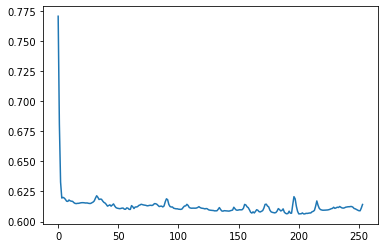

In [34]:

plt.plot(np.asarray(val_loss_g_))
best_model_test_loss_g

array(2.149334, dtype=float32)

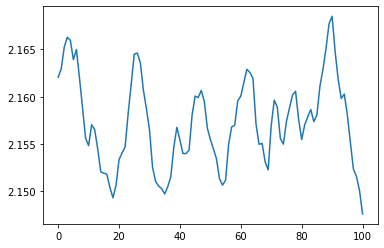

In [35]:

plt.plot(np.asarray(val_loss_q_))
best_model_test_loss_q